In [1]:
import pandas as pd

df = pd.read_csv('/content/archive_5.zip')  # Replace with your actual file path
print(df.shape)
print(df.head())
print(df['loan_status'].value_counts())


(32581, 12)
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                   

In [2]:
from sklearn.preprocessing import LabelEncoder

df['loan_status'] = df['loan_status'].map({'Default': 1, 'Non-Default': 0})  # adjust values if different

# Label encode categorical features
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Optional: fill missing values
df = df.fillna(df.median())


In [24]:
X = df.drop('loan_status', axis=1)
print("Total missing values in X:", X.isna().sum().sum())


Total missing values in X: 0


In [39]:
import pandas as pd

# Load the dataset fresh
df = pd.read_csv('/content/archive_5.zip')

# See exact unique values in 'loan_status'
print("🔍 Unique values in 'loan_status':")
print(df['loan_status'].unique())
print("\n🔢 Counts:")
print(df['loan_status'].value_counts(dropna=False))


🔍 Unique values in 'loan_status':
[1 0]

🔢 Counts:
loan_status
0    25473
1     7108
Name: count, dtype: int64


In [47]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Split successful!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Split successful!
Train shape: (26064, 11)
Test shape: (6517, 11)


In [48]:
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])


In [49]:
# Fill missing values in all columns with the median (numeric-safe)
df = df.fillna(df.median(numeric_only=True))


In [50]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [51]:
print("NaNs in X_train:", X_train.isna().sum().sum())
print("NaNs in X_test:", X_test.isna().sum().sum())


NaNs in X_train: 0
NaNs in X_test: 0


In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_probs_lr = lr.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_cost(y_true, y_probs, threshold, cost_fp=1000, cost_fn=300):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp * cost_fp) + (fn * cost_fn)


In [54]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.9, 50)
costs = [calculate_cost(y_test, y_probs_lr, t) for t in thresholds]

best_threshold = thresholds[np.argmin(costs)]
min_cost = min(costs)

print(f"✅ Best Threshold: {best_threshold:.2f}")
print(f"💰 Minimum Business Cost: ${min_cost}")


✅ Best Threshold: 0.72
💰 Minimum Business Cost: $396400


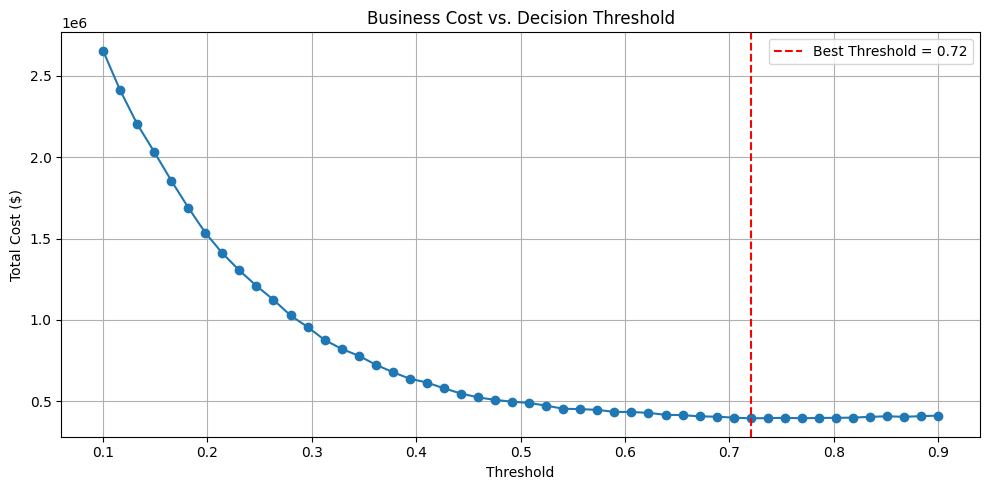

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, costs, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('Business Cost vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Cat boost

In [57]:
def calculate_cost(y_true, y_probs, threshold, cost_fp=1000, cost_fn=300):
    from sklearn.metrics import confusion_matrix
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp * cost_fp) + (fn * cost_fn)


In [59]:
!pip install catboost --quiet
from catboost import CatBoostClassifier

# Train the CatBoost model
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

# Predict probabilities for the positive class (default = 1)
y_probs_cat = cat.predict_proba(X_test)[:, 1]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [60]:
import numpy as np
import matplotlib.pyplot as plt

thresholds_cat = np.linspace(0.1, 0.9, 50)
costs_cat = [calculate_cost(y_test, y_probs_cat, t) for t in thresholds_cat]

best_threshold_cat = thresholds_cat[np.argmin(costs_cat)]
min_cost_cat = min(costs_cat)

print(f"🐱 CatBoost Best Threshold: {best_threshold_cat:.2f}")
print(f"💰 CatBoost Minimum Business Cost: ${min_cost_cat}")


🐱 CatBoost Best Threshold: 0.64
💰 CatBoost Minimum Business Cost: $129900


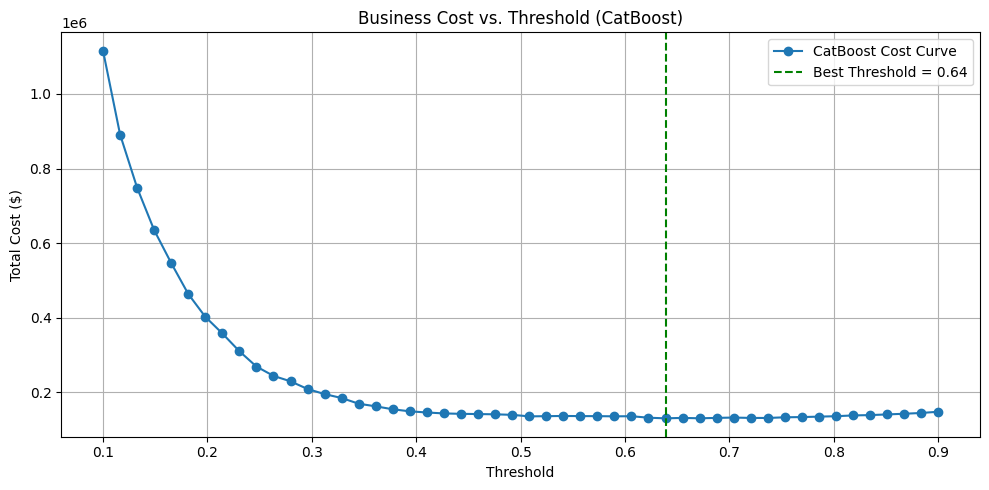

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds_cat, costs_cat, marker='o', label='CatBoost Cost Curve')
plt.axvline(best_threshold_cat, color='green', linestyle='--', label=f'Best Threshold = {best_threshold_cat:.2f}')
plt.title('Business Cost vs. Threshold (CatBoost)')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
